# COHRA1 Feature Analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from lib.cohra_vars import (
    COHRA_DFA_columns,
    COHRA_DFS_columns,
    COHRA_fear_of_pain_columns,
    COHRA_DFS_and_fear_of_pain_columns,
    COHRA_demographics_columns,
    COHRA_caries_exam_columns
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split, LearningCurveDisplay, learning_curve
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint # for integer distributions
import shap

---

## Load COHRA1 data

In [3]:
cohra1_df = pd.read_excel('DFA-data/COHRA/COHRA1.xlsx')
cohra1_df.shape

(3903, 933)

---

## Build subset of data that includes demographics, first visit, DFA, and caries exam data

### Subset data to first visit

In [4]:
subset_df = cohra1_df[cohra1_df.VISIT == 1]
subset_df.shape

(2862, 933)

### Replace values -5555, -6666, and -9999 with 0

In [5]:
subset_df = subset_df.replace(-5555, 0)
subset_df = subset_df.replace(-6666, 0)
subset_df = subset_df.replace(-9999, 0)
subset_df.shape

(2862, 933)

### replace 9 with 0 in DFS and fear of pain columns

In [6]:
subset_df[COHRA_DFS_and_fear_of_pain_columns] = subset_df[COHRA_DFS_and_fear_of_pain_columns].replace(9, 0)
subset_df.shape

(2862, 933)

---

## Correlations in DFS data  
The `spearman` method is used for ordninal data, but (I think) `kendall` can also be used.  
I tested with `kendall`. The results still showed strong correlations, but the lower valus were in ~0.78 range instead of ~0.86.

<Axes: >

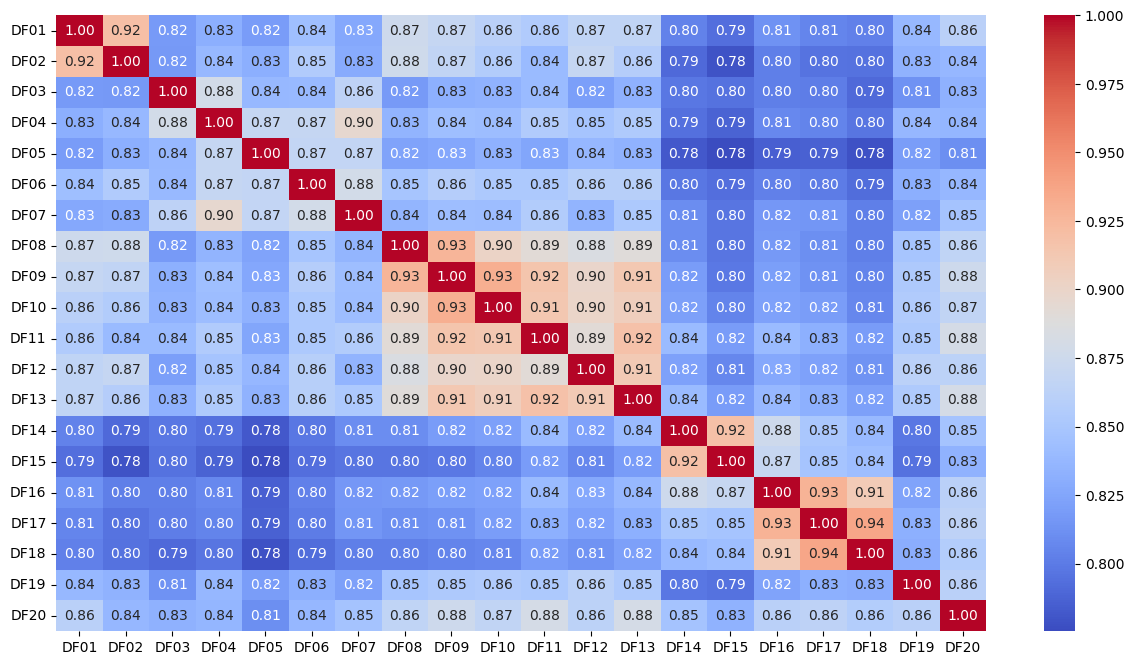

In [7]:
correlations = subset_df[COHRA_DFS_columns].corr(method='kendall')
plt.figure(figsize=(15, 8)) # Adjust figure size as needed
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")

---

## Correlations in fear of pain data
Using `kendall`, the lower range was ~0.75.

<Axes: >

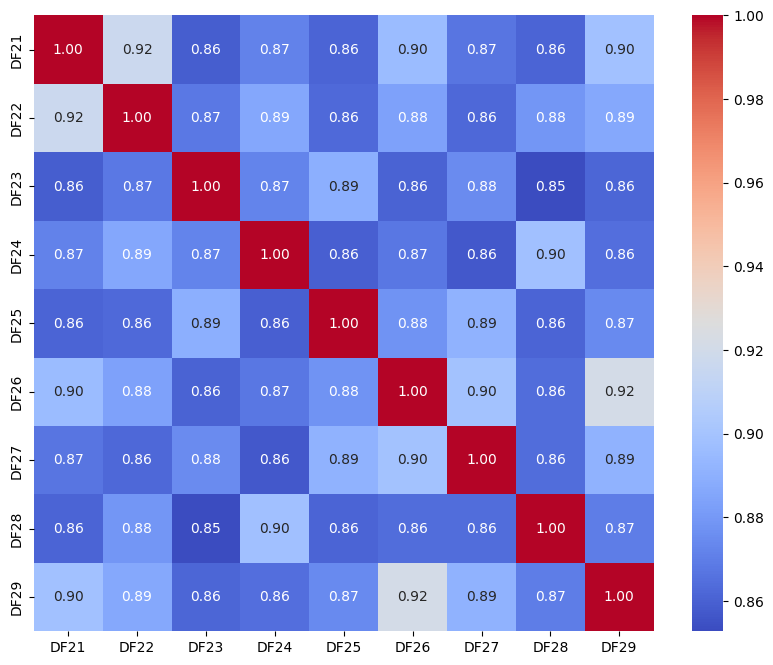

In [8]:
correlations = subset_df[COHRA_fear_of_pain_columns].corr(method='spearman')
plt.figure(figsize=(10, 8)) # Adjust figure size as needed
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")

---

## Correlations in DFS and fear of pain data
Using `kendall`, the lower range was ~0.70.

<Axes: >

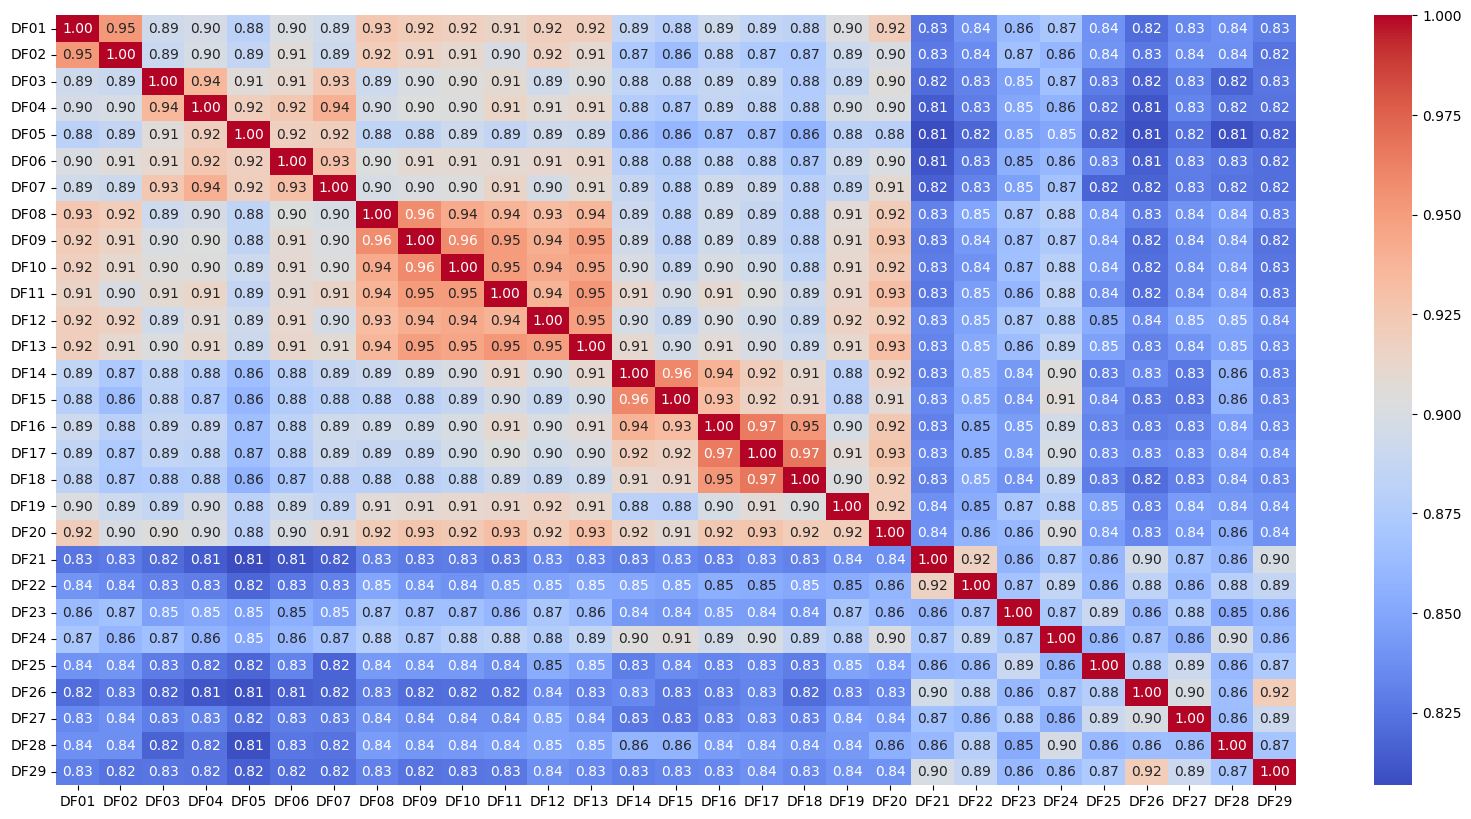

In [9]:
correlations = subset_df[COHRA_DFS_and_fear_of_pain_columns].corr(method='spearman')
plt.figure(figsize=(20, 10)) # Adjust figure size as needed
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")

## Plot counts for all DFS questions

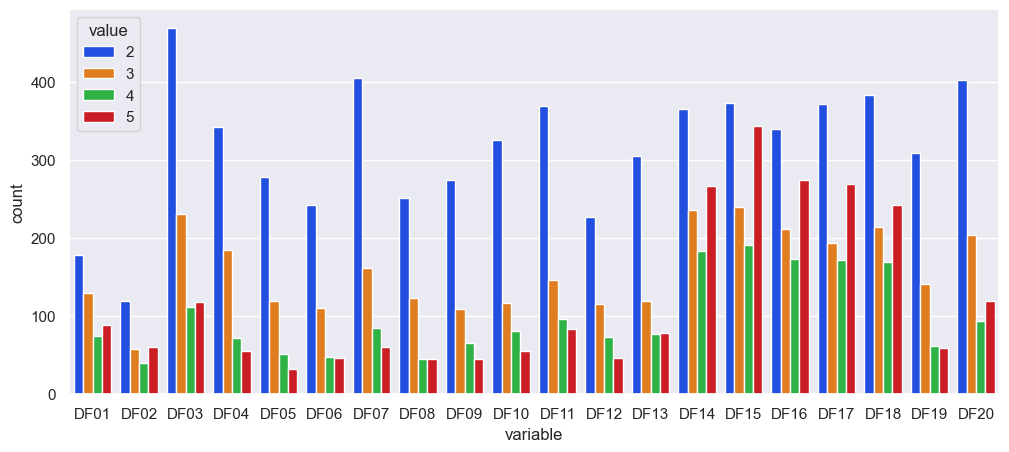

In [10]:
sns.set()
plt.figure(figsize=(12, 5))
plot_df = subset_df[COHRA_DFS_columns].melt().groupby(['variable', 'value']).agg(count=('variable', 'size')).reset_index()
sns.barplot(
    data= plot_df[plot_df.value > 1],
    x='variable', 
    y='count',
    hue='value',
    palette='bright'
)
plt.show()

## Females vs Males DFS questions

<Figure size 1200x500 with 0 Axes>

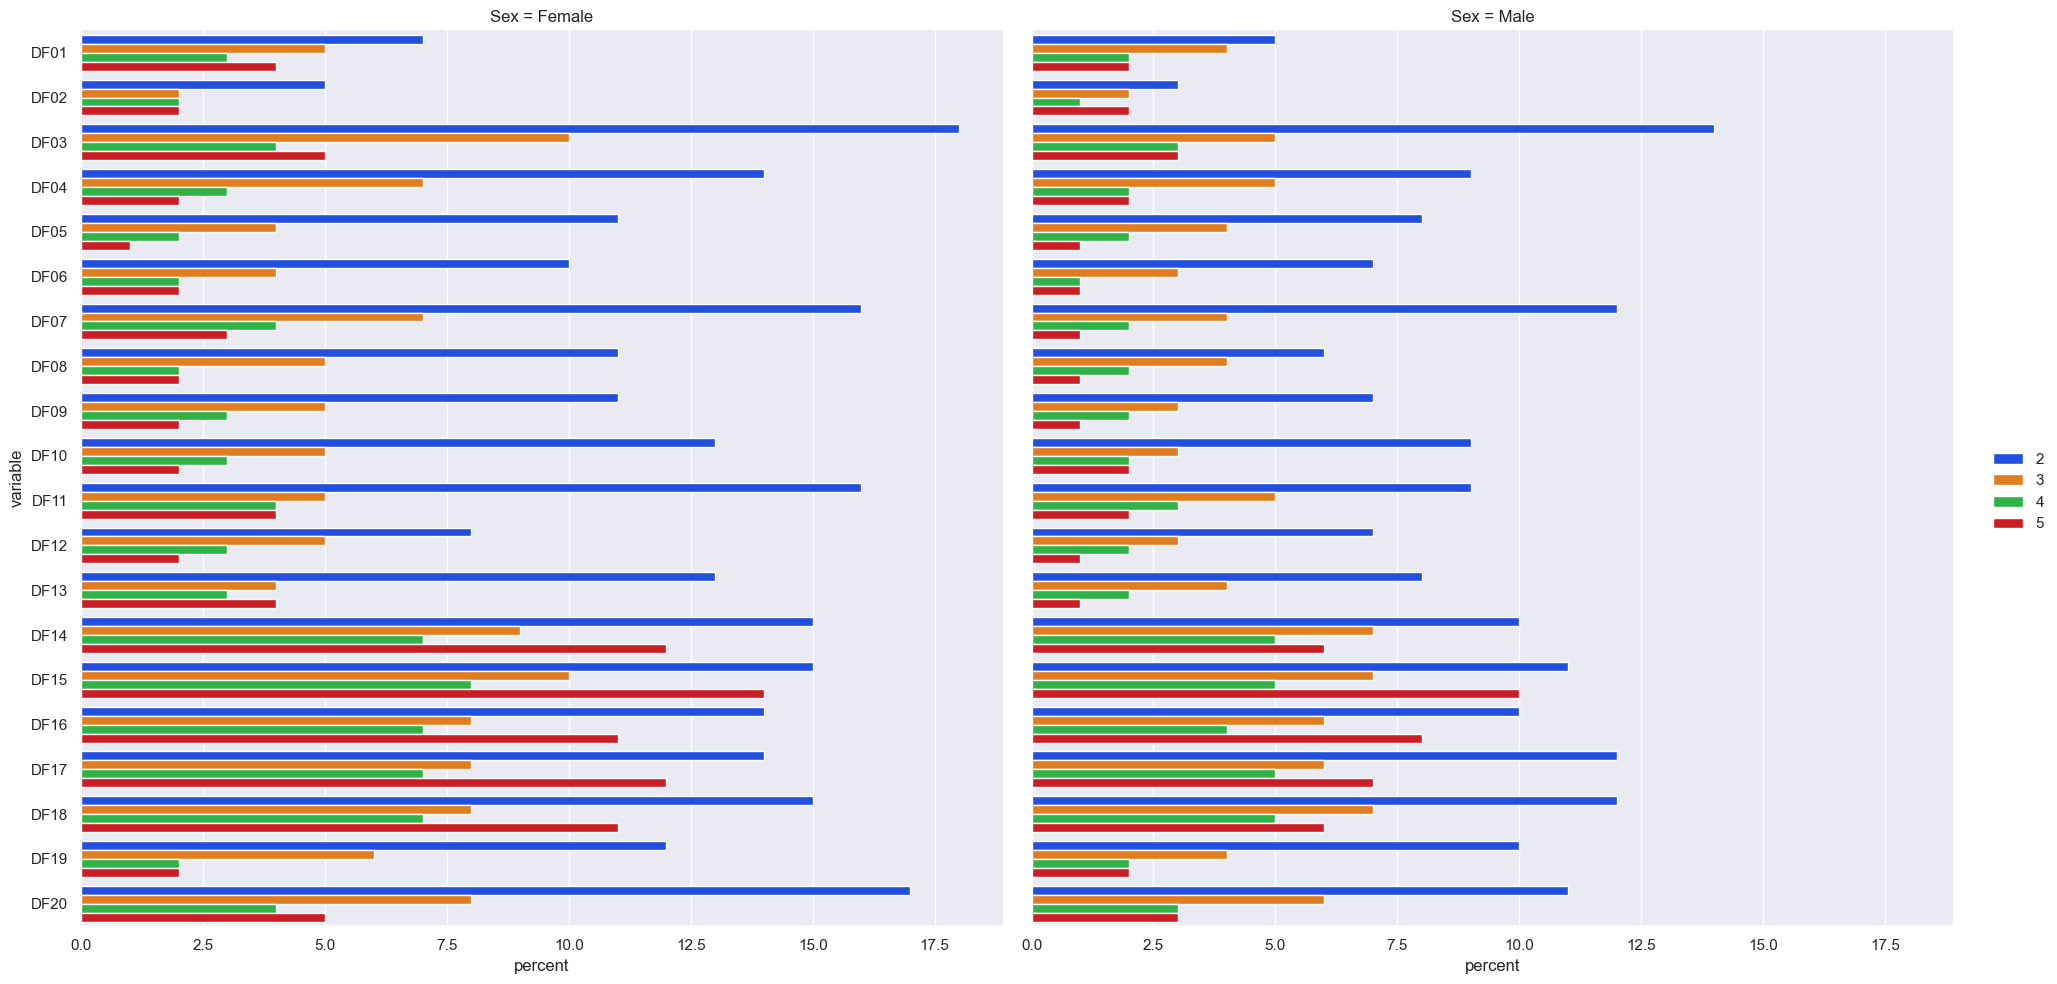

In [11]:
sns.set()
num_males = len(subset_df.Sex[subset_df.Sex==1])
num_females = len(subset_df.Sex[subset_df.Sex==2])

plt.figure(figsize=(12, 5))
plot_df = subset_df[['Sex'] + COHRA_DFS_columns].melt(id_vars='Sex')
plot_df = plot_df.query('Sex > 0 and value > 1')
plot_df.Sex = np.where(plot_df.Sex == 1, 'Male', 'Female')
plot_df = plot_df.groupby(['Sex', 'variable', 'value']).agg(count=('variable', 'size')).reset_index()

plot_df['percent'] = plot_df.apply(
    lambda x: round(x['count']/num_males, 2) * 100 if x['Sex'] == 'Male' else round(x['count']/num_females, 2) * 100, axis=1
)

g = sns.FacetGrid(plot_df, col='Sex', height=10, aspect=1, sharey=True)
g.map_dataframe(sns.barplot, y='variable', x='percent', hue='value',  palette='bright')
g.add_legend()
g.tight_layout()

----

## Random forest variable importance

### Create train and test data

In [12]:
X = subset_df[COHRA_DFS_columns]
y = subset_df.TotalDFSScore

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Search for best paramaters

In [14]:
[random.randint(0,100) for i in range(10)]

[73, 90, 14, 29, 26, 22, 65, 16, 30, 0]

In [15]:
# list compressions of the form [random.randint(Y, Z) for i in range(X)] generate a list of X random numbers between Y and Z
param_grid = {
    'criterion' :['squared_error', 'friedman_mse', 'poisson', 'absolute_error', 'r2_error'],
    'n_estimators': randint(100, 500), # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2', 0.6, 0.8, None], # Number of features to consider at each split
    'max_depth': [random.randint(10, 100)  for i in range(10)], # Maximum depth of the tree
    'min_samples_split': [random.randint(2, 20) for i in range(10)], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [random.randint(1, 10) or i in range(5)], # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False], # Whether bootstrap samples are used when building trees
    'oob_score': [True, False],
}

In [16]:
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(),
    param_distributions=param_grid,
    n_iter=50, # Number of parameter settings that are sampled
    cv=5, # Number of cross-validation folds
    verbose=0, # Controls the verbosity of the output
    random_state=42,
    n_jobs=-1 # Use all available CPU cores
)

In [17]:
random_search.fit(X_train, y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
95 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 1358, in wrapper
    estimator._validate_params()
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 471, in _validate_params
    validate_parameter_constraints(
  File "/opt/homebrew/lib/python3.11/site-packages

,estimator,RandomForestRegressor()
,param_distributions,"{'bootstrap': [True, False], 'criterion': ['squared_error', 'friedman_mse', ...], 'max_depth': [87, 69, ...], 'max_features': ['auto', 'sqrt', ...], ...}"
,n_iter,50
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [18]:
random_search.best_params_

{'bootstrap': True,
 'criterion': 'absolute_error',
 'max_depth': 14,
 'max_features': 0.8,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 202,
 'oob_score': False}

In [19]:
model = random_search.best_estimator_

In [20]:
# Make predictions
y_pred = model.predict(X_test)

In [21]:
print('r2_score:', r2_score(y_test, y_pred))
print('mean_squared_error:', mean_squared_error(y_test, y_pred))
print('root_mean_squared_error:', root_mean_squared_error(y_test, y_pred))
print('mean_absolute_error:', mean_absolute_error(y_test, y_pred))
if model.oob_score:
    print('oob_score_:', model.oob_score_)

r2_score: 0.908069965772596
mean_squared_error: 47.93222524220833
root_mean_squared_error: 6.923310280653925
mean_absolute_error: 2.253829430562104


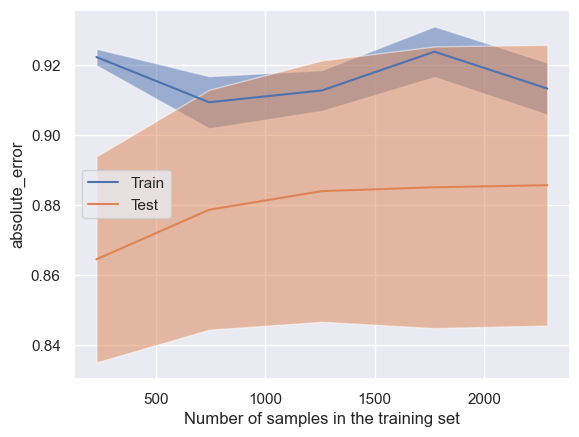

In [26]:
LearningCurveDisplay.from_estimator(model, X, y, score_name='absolute_error')
plt.show()

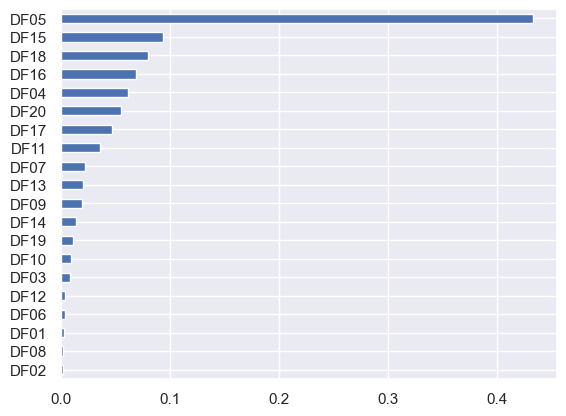

In [24]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values()
feat_importances.plot(kind='barh')
# feat_importances.nlargest(5).plot(kind='barh') # to see top 5
plt.show()

In [29]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

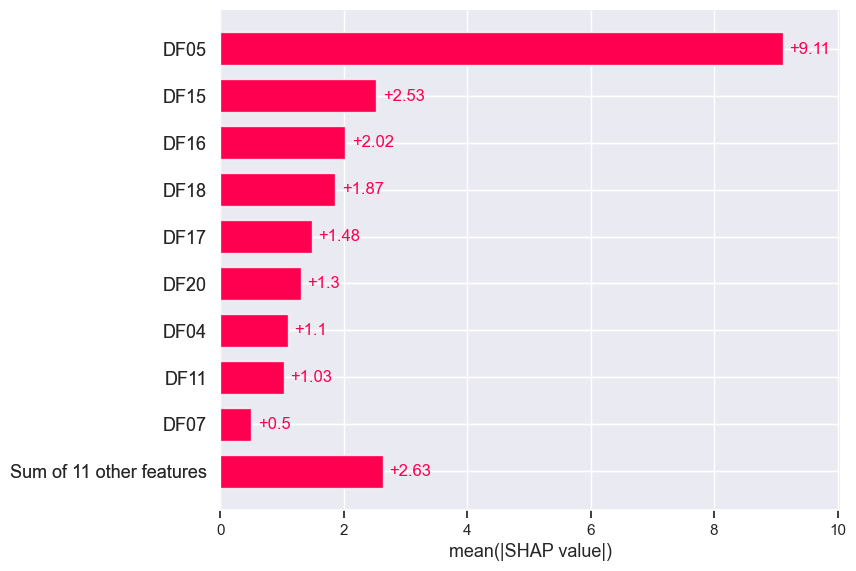

In [41]:
shap.plots.bar(explainer(X_test))

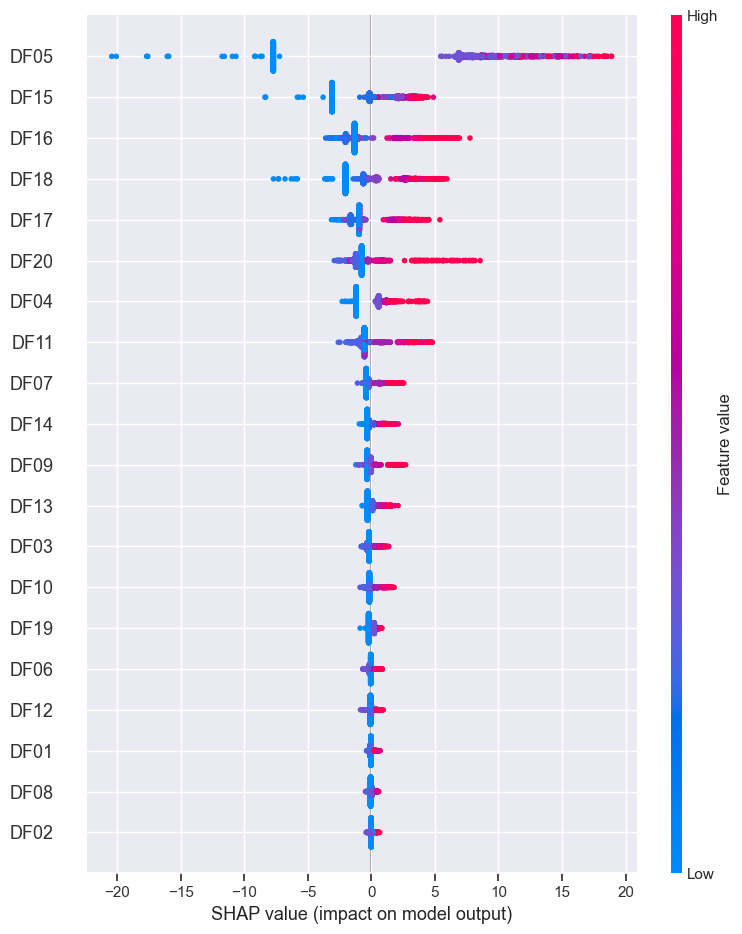

In [42]:
shap.summary_plot(shap_values, X_test)